# Integration Lab

In this lab, you will explore two important challenges in numerical integration:

1. Handling improper integrals using coordinate transformation.
   Many real-world integrals have infinite limits or singularities.
   Direct numerical integration often fails, so we apply **variable transformations** to map the integral to a finite domain.
  
2. Investigating convergence properties for functions with discontinuities.
   Standard numerical methods assume smoothness for high accuracy.
   If the function has a **jump discontinuity**, we will observe how the convergence rate deteriorates.

## Handling an Improper Integral via Coordinate Transformation

Consider the improper integral:
\begin{align}
I = \int_0^{\infty} \frac{1}{1 + x^2} dx.
\end{align}

This integral is well-known, and its exact value is:
\begin{align}
I = \frac{\pi}{2}.
\end{align}

However, standard numerical integration methods fail because the domain extends to **infinity**.
To solve this, we introduce a **coordinate transformation** that maps the infinite domain $[0, \infty)$ to a finite domain $[0,1]$.

### Coordinate Transformation

A common transformation is:
\begin{align}
x = \frac{t}{1 - t}, \quad \text{where } t \in [0,1].
\end{align}

Differentiating,
\begin{align}
dx = \frac{dt}{(1 - t)^2}.
\end{align}

Rewriting the integral in terms of $t$:
\begin{align}
I
&= \int_0^1 \frac{1}{1 + \left(\frac{t}{1 - t}\right)^2} \frac{dt}{(1 - t)^2} \\
&= \int_0^1 \frac{dt}{(1-t)^2 + t^2} \\
&= \int_0^1 \frac{dt}{1 - 2t + 2t^2}
\end{align}

This transforms the infinite limit $x = \infty$ to the finite limit $t = 1$, allowing us to apply numerical integration techniques.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# HANDSON: Define the original function
def f(x): 
    return 1 / (1 + x ** 2)


In [13]:
# HANDSON: Define the transformed function
def ft(t): 
    x= t / (1 - t)
    xd = 1 / (1 - t) ** 2
    return f(x) * xd


In [14]:
# HANDSON: Implement Middle Riemann Sum
def middle(f, N, a=0, b=1):
    D = (b - a) / N
    X = [D * (i + 0.5) + a for i in range(N)]
    return np.sum(f(np.array(X))) * D

In [15]:
# Perform the integration using the transformed variable
N = 64  # Number of sub-intervals
I = np.pi / 2
I_middle = middle(ft, N)

# Print results
print(f"Middle Riemann Sum (N={N}): {I_middle}")
print(f"Exact Integral: {I}")
print(f"Absolute Error: {abs(I_middle - I)}")

Middle Riemann Sum (N=64): 295.6299216556968
Exact Integral: 1.5707963267948966
Absolute Error: 294.0591253289019


## Integrating a Function with a Jump Discontinuity

Many numerical integration methods assume smoothness of the function.
However, when the function has a jump discontinuity, the convergence rate degrades significantly.

Consider the function:
\begin{align}
f(x) = \sin(\pi x) +
\begin{cases}
0, & 0 \leq x < 0.5 \\
1, & 0.5 \leq x \leq 1
\end{cases}
\end{align}

We compute the definite integral:
\begin{align}
I = \int_0^1 f(x) dx.
\end{align}

Since the function is piecewise constant, the exact integral is $2/\pi + 1/2$.
However, standard numerical integration methods will struggle to approximate this accurately due to the jump at $x = 0.5$.

In [9]:
# HANDSON: Define the left and right functions
import numpy as np
def fL(x):
    return np.sin(np.pi * x)

def fR(x):
    return np.sin(np.pi * x) + 1

def f(x):
    return np.where(x < 0.5, fL(x), fR(x))

In [10]:
# HANDSON: Implement the Trapezoidal Rule
def trapezoidal(f, N=8, a=0, b=1):
    X, D = np.linspace(a, b, N+1, retstep=True)
    return np.sum(f(X[1:]) + f(X[:-1])) * 0.5 * D

In [11]:
# HANDSON: Implement Simpson's Rule
def simpson(f, N=8, a=0, b=1):
    X, D = np.linspace(a, b, N+1, retstep=True)
    S = 0
    for i in range(N // 2):
        l = X[2 * i]
        m = X[2 * i + 1]
        r = X[2 * i + 2]
        S += D * (f(l) + 4 * f(m) + f(r)) / 3
    return S

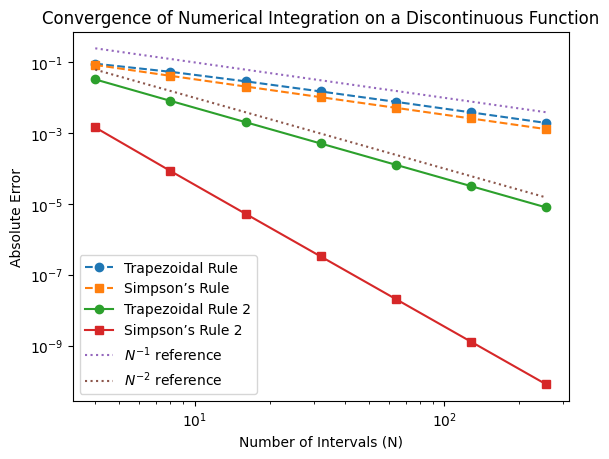

In [12]:
# Compute exact integral
I = 2/np.pi + 0.5

# Compare convergence for different methods
Ns = [4, 8, 16, 32, 64, 128, 256]
errs_trap  = []
errs_simp  = []
errs_trap2 = []
errs_simp2 = []

for N in Ns:
    I_trap  = trapezoidal(f, N)
    I_simp  = simpson    (f, N)
    I_trap2 = trapezoidal(fL, N//2, 0, 0.5) + trapezoidal(fR, N//2, 0.5, 1)
    I_simp2 = simpson    (fL, N//2, 0, 0.5) + simpson    (fR, N//2, 0.5, 1)
    errs_trap .append(abs(I_trap  - I))
    errs_simp .append(abs(I_simp  - I))
    errs_trap2.append(abs(I_trap2 - I))
    errs_simp2.append(abs(I_simp2 - I))

# Plot error convergence
plt.loglog(Ns, errs_trap,  'o--', label='Trapezoidal Rule')
plt.loglog(Ns, errs_simp,  's--', label='Simpson’s Rule')
plt.loglog(Ns, errs_trap2, 'o-',  label='Trapezoidal Rule 2')
plt.loglog(Ns, errs_simp2, 's-',  label='Simpson’s Rule 2')
plt.loglog(Ns, np.array(Ns)**(-1.), ':', label=r'$N^{-1}$ reference')
plt.loglog(Ns, np.array(Ns)**(-2.), ':', label=r'$N^{-2}$ reference')
plt.xlabel('Number of Intervals (N)')
plt.ylabel('Absolute Error')
plt.legend()
plt.title('Convergence of Numerical Integration on a Discontinuous Function')
plt.show()

Observations
1. Degraded Convergence Rate
   * For smooth functions, Simpson's rule is expected to converge at $\mathcal{O}(N^{-4})$.
   * However, due to the discontinuity at $x = 0.5$, it instead converges at $\mathcal{O}(N^{-1})$.
2. Poor Accuracy for Large (N)
   * Increasing (N) does not always help significantly because the integration points do not align with the discontinuity.
3. Potential Fixes
   * Refinement Near the Discontinuity: Placing additional points near $x = 0.5$ (which we didn't implement).
   * Splitting the Integral: Compute separate integrals for $[0, 0.5]$ and $[0.5, 1]$.